In [1]:
# Append path for package
import sys
sys.path.append("../src")

from pathlib import Path
import re

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from mosaic_thickness import snowdepth_file, load_data, MAGNAPROBE_PATH, get_filename, plot_thickness_profile

filepath = Path('../data/mosaic-transect-actionlog-updated.xlsx')

## Parse MOSAiC transect action log

This file contains a lot of information but is not in a very friendly format for automated processing.  It will need reformatting to take full benefit of the information.  However, for now, I just want the names of Magnaprobe transects that have both GEM-2 ice thickness and Magnaprobe snow depths.

In [27]:
df = pd.read_excel(filepath, index_col=0, parse_dates=True)
# Rename columns to get rid of whitespace, parenthesis and '.'
newcol = []
for col in df.columns:
    newcol.append('_'.join([s.lower().replace('(','').replace(')','').replace('.','').replace('-','') for s in re.split(' | \n|\n', col) if s != '']))
df.columns = newcol
df.index = pd.Series(df.index).fillna(method='ffill').values
df.drop(df.index[df.index.str.contains('LEG')], inplace=True)
df.index = pd.to_datetime(df.index)

In [28]:
df.head()

,ice+snow_locations,gem2_ice_thickness,magnaprobe_snow_depth,drill_holes_ridge_transects,remote_sensing_locations,kukaradar_backscatter,balamis_radiometer_lband_emissivity,snow_pit_locations,snow_micropen,snow_water_equivalent,snow_salinity_samples,spectral_albedo,broadband_albedo,near_infrared_photography,structure_for_motion_photography,salinity_and_temp_measurements_ysi,logbook_link,notes
2019-10-24,Northern Loop,PS122/1_4-2,PS122/1_4-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-24,Calibration,PS122/1_4-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-31,Northern Loop,PS122/1_5-25,PS122/1_5-27,NaN,Northern Loop RS,NaN,PS122/1_5-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://spaces.awi.de/display/FSPSD/2019/10/31...,NaN
2019-10-31,Southern Loop,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-31,Calibration,PS122/1_6-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Find Transects with both GEM-2 ice thickness and Magnaprobe snow depths

In [29]:
df = df[df["gem2_ice_thickness"].notnull() & df["magnaprobe_snow_depth"].notnull()]

Some magnaprobe transects have multiple transect ids.  Other fields contain notes.  For themoment, I just get rid of these.

The regex to do this is a monster.

In [30]:
test = df["magnaprobe_snow_depth"].str.match("^\s*PS-*122[_/-]\d[_-]\d{1,2}-\d{1,3}\s*$").values
df = df[test]

In [31]:
def fix_transect_id(s):
    """Fixes random formatting of transect ids"""
    rs = re.sub('(?<=PS122)/|(?<=PS122)_','-',s.strip())
    rs = re.sub('(?<=PS122-\d)-','_',rs)
    rs = re.sub('(?<=PS)-','',rs)
    return rs

In [32]:
filepath = [MAGNAPROBE_PATH / f for f in df.index.strftime("%Y%m%d").values + "-" + df["magnaprobe_snow_depth"].apply(fix_transect_id).values]
filepath = [f for f in filepath if f.exists()]
filepath[:5]

[PosixPath('/home/apbarret/Data/Sunlight_under_seaice/MOSAiC_magnaprobe/20191024-PS122-1_4-1'),
 PosixPath('/home/apbarret/Data/Sunlight_under_seaice/MOSAiC_magnaprobe/20191031-PS122-1_5-27'),
 PosixPath('/home/apbarret/Data/Sunlight_under_seaice/MOSAiC_magnaprobe/20191107-PS122-1_6-50'),
 PosixPath('/home/apbarret/Data/Sunlight_under_seaice/MOSAiC_magnaprobe/20191114-PS122-1_7-62'),
 PosixPath('/home/apbarret/Data/Sunlight_under_seaice/MOSAiC_magnaprobe/20191121-PS122-1_8-58')]

Get a list of non-problematic filenames

In [33]:
savefiles = []
for fp in filepath:
    try:
        fn = get_filename(fp)
        df = load_data(fn)
        if (df.melt_pond_depth_m > 0.).any():
            print(f"{fn}: Melt Pond!")
        savefiles.append(fn)
    except Exception as err:
        pass
        #print(err)

/home/apbarret/Data/Sunlight_under_seaice/MOSAiC_magnaprobe/20200627-PS122-4_44-267/magna+gem2-transect-20200627_PS122-4_44-267_transect.csv: Melt Pond!
/home/apbarret/Data/Sunlight_under_seaice/MOSAiC_magnaprobe/20200629-PS122-4_45-198/magna+gem2-transect-20200629_PS122-4_45-198_transect.csv: Melt Pond!
/home/apbarret/Data/Sunlight_under_seaice/MOSAiC_magnaprobe/20200702-PS122-4_45-200/magna+gem2-transect-20200702_PS122-4_45-200_transect.csv: Melt Pond!
/home/apbarret/Data/Sunlight_under_seaice/MOSAiC_magnaprobe/20200703-PS122-4_45-201/magna+gem2-transect-20200703_PS122-4_45-201_transect.csv: Melt Pond!
/home/apbarret/Data/Sunlight_under_seaice/MOSAiC_magnaprobe/20200704-PS122-4_45-202/magna+gem2-transect-20200704_PS122-4_45-202_transect.csv: Melt Pond!
/home/apbarret/Data/Sunlight_under_seaice/MOSAiC_magnaprobe/20200705-PS122-4_45-203/magna+gem2-transect-20200705_PS122-4_45-203_transect.csv: Melt Pond!
/home/apbarret/Data/Sunlight_under_seaice/MOSAiC_magnaprobe/20200708-PS122-4_46-23

In [89]:
df = load_data('/home/apbarret/Data/Sunlight_under_seaice/MOSAiC_magnaprobe/20200627-PS122-4_44-267/magna+gem2-transect-20200627_PS122-4_44-267_transect.csv')

In [90]:
df.head()

,lon,lat,local_x,local_y,snow_depth_m,melt_pond_depth_m,surface_type,ice_thickness_18khz_ip_m,ice_thickness_5khz_ip_m,ice_thickness_93khz_ip_m,ice_thickness_mean_m,transect_distance_m
Date/Time,,,,,,,,,,,,
2020-06-27 11:22:46,9.89478,81.95278,-153.212507,-73.419080,0.05502,0.0,1,3.521437,4.030694,4.144066,3.898732,0.000000
2020-06-27 11:22:55,9.89510,81.95277,-157.810002,-70.192152,0.05277,0.0,1,3.667773,4.484344,4.169916,4.107344,5.616941
2020-06-27 11:23:09,9.89550,81.95272,-161.934210,-66.335585,0.09930,0.0,1,3.426157,3.726871,3.917157,3.690062,11.263374
2020-06-27 11:23:17,9.89592,81.95270,-164.498767,-58.848335,0.09980,0.0,1,2.872571,2.935657,3.384771,3.064333,19.177656
2020-06-27 11:23:24,9.89624,81.95268,-168.702058,-53.028117,0.06230,0.0,1,3.049500,3.307100,3.552843,3.303148,26.356972


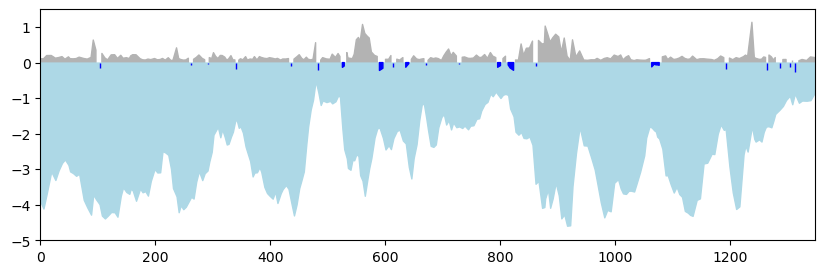

In [36]:
fig, ax = plt.subplots(figsize=(10,3))
plot_thickness_profile(df, ax=ax)

## Run SeaIceRT of transect with melt pond

In [47]:
from ccsm3_sir_de import SeaIceRT

def seaicert_mp(df):
    """Runs the SeaIceRT model for multiple points.  Output is returned as a pandas.DataFrame"""
    
    model = SeaIceRT()

    model.snow_grain_radius = 180.

    day_of_year = df.index.day_of_year
    lat = df.lat.values
    snow_depth_m = df.snow_depth_m.values
    melt_pond_depth_m = df.melt_pond_depth_m.values
    ice_thickness_mean_m = df.ice_thickness_mean_m.values
    
    thiszip = zip(
        day_of_year,
        lat,
        snow_depth_m,
        melt_pond_depth_m,
        ice_thickness_mean_m,
    )
    
    distance = []
    sw_absorbed_by_ocean = []
    surface_albedo = []
    surface_downwelling_radiative_flux = []
    #for idx, vals in df.iterrows():
    for iday_of_year, ilat, isnow_depth_m, imelt_pond_depth_m, iice_thickness_mean_m in thiszip:
        model.day_of_year = iday_of_year + 0.5  # adjust for longitude?
        model.latitude = ilat
        model.snow_depth = isnow_depth_m
        model.pond_depth = imelt_pond_depth_m
        model.sea_ice_thickness = iice_thickness_mean_m
    
        model.run()
        output = model.get_results()
        #distance.append(vals.transect_distance_m)
        sw_absorbed_by_ocean.append(output["downwelling_shortwave_flux_absorbed_by_ocean"])
        surface_albedo.append(output["surface_albedo"])
        surface_downwelling_radiative_flux.append(output["surface_downwelling_radiative_flux"])
        
    result = pd.DataFrame(
        {
            'datetime': df.index.values,
            'latitude': df.lat.values,
            'snow_depth_m': df.snow_depth_m.values,
            'melt_pond_depth_m': df.melt_pond_depth_m.values,
            'ice_thickness_mean_m': df.ice_thickness_mean_m.values,
            'sw_absorbed_by_ocean': sw_absorbed_by_ocean,
            'surface_albedo': surface_albedo,
            'surface_downwelling_radiative_flux': surface_downwelling_radiative_flux,
            'transect_distance_m': df.transect_distance_m.values,
        },
        index = df.transect_distance_m,
    )
    return result
            

In [48]:
def plot_results(df):

    distance = df.index.values
    sw_absorbed_by_ocean = df.sw_absorbed_by_ocean
    surface_downwelling_radiative_flux = df.surface_downwelling_radiative_flux
    surface_albedo = df.surface_albedo
    
    t0 = distance[0]
    t1 = distance[-1]

    fig, ax = plt.subplots(4, 1, figsize=(10,7))
    ax[0].set_xlim(t0, t1)
    ax[0].plot(distance, sw_absorbed_by_ocean)
    ax[0].set_ylim(np.array(ax[0].get_ylim()) * np.array([0., 1.1]))
    ax[0].set_ylabel("$\mathrm{W\ m^{-2}}$")
    ax[0].text(0.01, 0.89, "SW absorbed by Ocean", transform=ax[0].transAxes)
    ax[0].set_xticklabels([])

    ax[1].set_xlim(t0, t1)
    ax[1].plot(distance, surface_downwelling_radiative_flux)
    ax[1].set_ylim(np.array(ax[1].get_ylim()) * np.array([0., 1.2]))
    ax[1].set_ylabel("$\mathrm{W\ m^{-2}}$")
    ax[1].text(0.01, 0.89, "Surface downwelling flux", transform=ax[1].transAxes)
    ax[1].set_xticklabels([])

    ax[2].set_xlim(t0, t1)
    ax[2].set_ylim(0., 1.1)
    ax[2].plot(distance, surface_albedo)
    ax[2].text(0.01, 0.89, "Surface Albedo", transform=ax[2].transAxes)
    ax[2].set_xticklabels([])

    plot_thickness_profile(df, ax=ax[3])
    ax[3].set_xlabel('m')

    fig.subplots_adjust(hspace=0.1)

#fig.savefig('radiative_transfer.PS122-4_44-267.png')

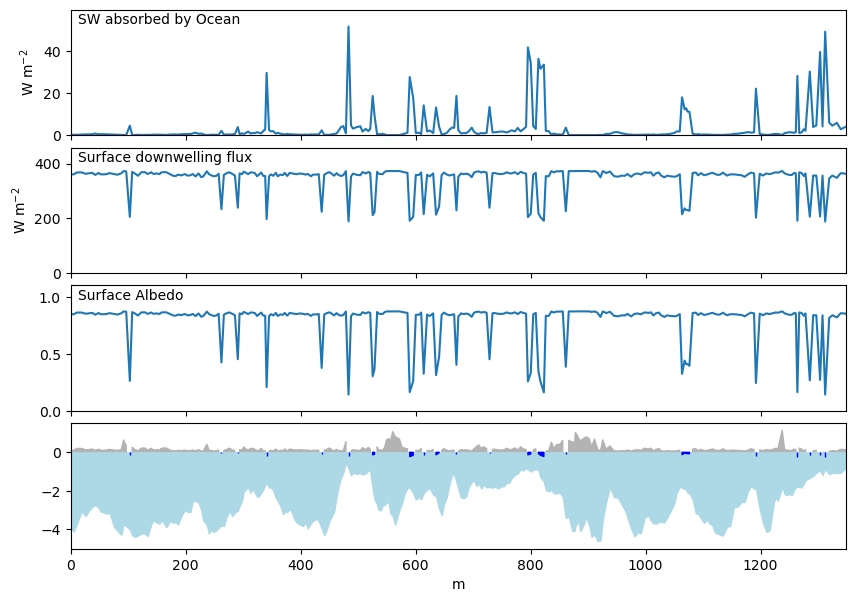

In [49]:
rt_df = seaicert_mp(df)
plot_results(rt_df)

In [94]:
import warnings

agg_result = []
index = []
for fp in savefiles:
    #print(f"Running {fp}")
    df = load_data(fp)
    index.append(df.index[0])
    rt_df = seaicert_mp(df)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=FutureWarning)
        rt_df_mean = rt_df.mean()
        rt_df_mean["pond_fraction"] = (df.melt_pond_depth_m > 0.).sum() / len(df)
        agg_result.append(rt_df_mean)
        
#time_series_df = pd.DataFrame(agg_result, index=index)

In [95]:
time_series_df = pd.concat(agg_result, axis=1).T
time_series_df.index = index
# time_series_df[["surface_downwelling_radiative_flux", 
#                                  "sw_absorbed_by_ocean",
#                                  "surface_albedo"]] = time_series_df[["surface_downwelling_radiative_flux", 
#                                                                       "sw_absorbed_by_ocean",
#                                                                       "surface_albedo"]].where(time_series_df.surface_downwelling_radiative_flux > 0.)
time_series_df = time_series_df.where(time_series_df.surface_downwelling_radiative_flux > 0.).dropna(how='all')

In [96]:
time_series_df.head()

,latitude,snow_depth_m,melt_pond_depth_m,ice_thickness_mean_m,sw_absorbed_by_ocean,surface_albedo,surface_downwelling_radiative_flux,transect_distance_m,pond_fraction
2020-03-20 12:28:48,86.320012,0.276416,0.0,2.827835,0.048989,0.862939,28.402393,826.378365,0.0
2020-03-26 11:42:00,85.993010,0.285155,0.0,3.180240,0.064720,0.865854,52.608154,757.796953,0.0
2020-03-26 13:07:46,85.987113,0.099456,0.0,1.346686,0.857225,0.829570,50.354242,149.700230,0.0
2020-03-30 08:38:22,85.383635,0.251155,0.0,1.875517,0.106265,0.867358,74.268336,724.906012,0.0
2020-04-03 07:46:50,84.800291,0.284127,0.0,3.117478,0.077227,0.869034,97.230986,687.124740,0.0


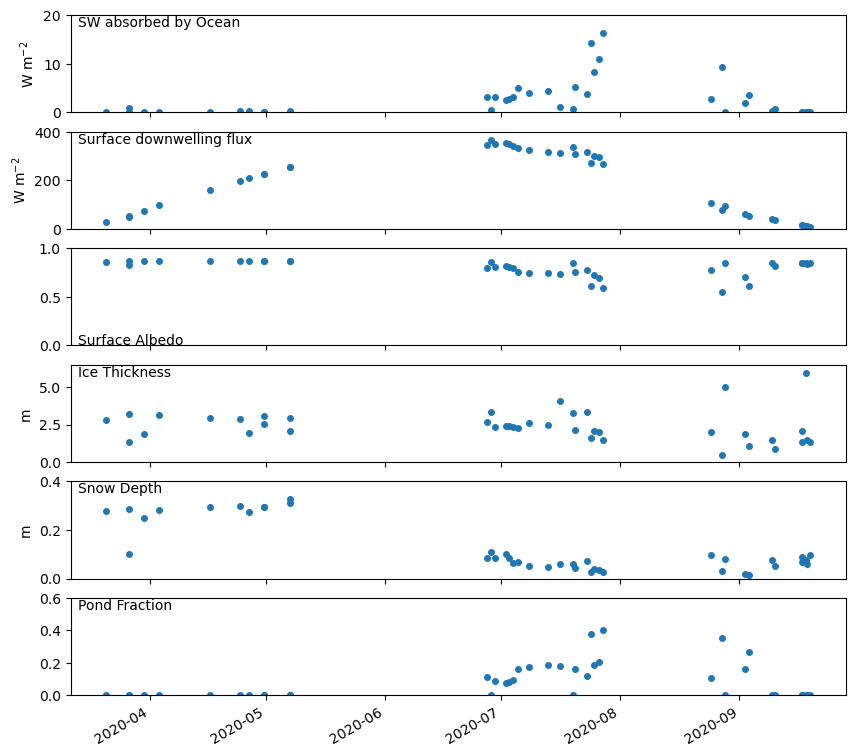

In [106]:
fig, ax = plt.subplots(6, 1, figsize=(10, 10))

time_series_df.sw_absorbed_by_ocean.plot(marker='o', ls='', markersize=4, ax=ax[0])
ax[0].set_ylim(0,20)
ax[0].set_ylabel("$\mathrm{W\ m^{-2}}$")
ax[0].text(0.01, 0.88, "SW absorbed by Ocean", transform=ax[0].transAxes)
ax[0].set_xticklabels([])

time_series_df.surface_downwelling_radiative_flux.plot(marker='o', ls='', markersize=4, ax=ax[1])
ax[1].set_ylim(0., 400.)
ax[1].set_ylabel("$\mathrm{W\ m^{-2}}$")
ax[1].text(0.01, 0.88, "Surface downwelling flux", transform=ax[1].transAxes)
ax[1].set_xticklabels([])

time_series_df.surface_albedo.plot(marker='o', ls='', markersize=4, ax=ax[2])
ax[2].set_ylim(0., 1.)
ax[2].text(0.01, 0.01, "Surface Albedo", transform=ax[2].transAxes)
ax[2].set_xticklabels([])

time_series_df.ice_thickness_mean_m.plot(marker='o', ls='', markersize=4, ax=ax[3])
ax[3].set_ylim(0., 6.5)
ax[3].set_ylabel('m')
ax[3].text(0.01, 0.88, "Ice Thickness", transform=ax[3].transAxes)
ax[3].set_xticklabels([])

time_series_df.snow_depth_m.plot(marker='o', ls='', markersize=4, ax=ax[4])
ax[4].set_ylim(0., .4)
ax[4].set_ylabel('m')
ax[4].text(0.01, 0.88, "Snow Depth", transform=ax[4].transAxes)
ax[4].set_xticklabels([])

time_series_df.pond_fraction.plot(marker='o', ls='', markersize=4, ax=ax[5])
ax[5].set_ylim(0., .6)
#ax[5].set_ylabel('m')
ax[5].text(0.01, 0.88, "Pond Fraction", transform=ax[5].transAxes)

fig.savefig('mosaic_time_series_from_transects.png')

In [71]:
time_series_df.head()

,latitude,snow_depth_m,melt_pond_depth_m,ice_thickness_mean_m,sw_absorbed_by_ocean,surface_albedo,surface_downwelling_radiative_flux,transect_distance_m
2019-10-24 05:23:21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-21 07:59:33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-28 06:01:29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-22 11:07:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-26 12:06:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
